In [4]:
import numpy as np
from neural_network.layer import *
from neural_network.net import *
from queue import Queue
import matplotlib.pyplot as plt
from tqdm import tqdm
from neural_network.trainutils import Dataset, PCADataset, train_test_split
import os
import seaborn as sns

import PIL.Image as Image

In [2]:
current_dir = os.getcwd()
face_dir = os.path.join(current_dir, "cmu+face+images", "faces")

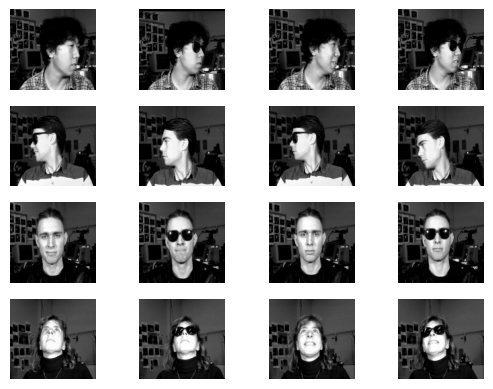

In [5]:
# Check example images
current_dir = os.getcwd()
orient_folder = "face_orientation"
location = os.path.join(current_dir, "cmu+face+images")
face_orientation =  os.path.join(location, orient_folder)

# Gather all data
keys = ["left", "right", "straight", "up"]
all_data = [(Image.open(os.path.join(face_orientation, key, image)).convert(mode="L"), key) for key in keys for image in os.listdir(os.path.join(face_orientation, key))]

plt.figure()
for row in range(4):
    for col in range(4):
        plt.subplot2grid((4, 4), (row, col))
        example = all_data[row*200 + col][0]
        plt.imshow(example, cmap="gray")
        plt.axis("off")
plt.savefig("plots/samples.pdf", format="pdf", bbox_inches="tight")

In [6]:
X = np.array([elem[0] for elem in all_data]) 
X = X.reshape((len(all_data), -1))/255.0 # (624, 120, 128) --> (624, 15360) and [0, 255] -> [0, 1]

In [7]:
shape = (120, 128)

In [8]:
def NNMF(data, shape=(120, 128), embedding_size=64, convergence=0.9999):

    nnmf_scaler = np.sqrt(np.mean(data)/data.shape[0])
    nnmf_loss = []

    # Initialize non-negative matrices
    W = abs(np.random.standard_normal((data.shape[0], embedding_size)))*nnmf_scaler
    H = abs(np.random.standard_normal((embedding_size, data.shape[-1])))*nnmf_scaler

    nnmf_loss.append(np.linalg.norm(data - np.matmul(W, H), "fro"))
    W, H = update(W, H, data)
    nnmf_loss.append(np.linalg.norm(data - np.matmul(W, H), "fro"))

    while nnmf_loss[-1]/nnmf_loss[-2] < convergence:
        
        W, H = update(W, H, data)
        nnmf_loss.append(np.linalg.norm(data - np.matmul(W, H), "fro"))
    
    return W, H, nnmf_loss


def NNMF_projection(test_data, H, shape=(120, 128), embedding_size=64, convergence=0.9999):

    nnmf_scaler = np.sqrt(np.mean(test_data)/test_data.shape[0])
    nnmf_loss = []

    W = abs(np.random.standard_normal((test_data.shape[0], embedding_size)))*nnmf_scaler

    nnmf_loss.append(np.linalg.norm(test_data - np.matmul(W, H), "fro"))
    W = update_W_only(W, H, test_data)
    nnmf_loss.append(np.linalg.norm(test_data - np.matmul(W, H), "fro"))

    while nnmf_loss[-1]/nnmf_loss[-2] < convergence:
        
        W = update_W_only(W, H, test_data)
        nnmf_loss.append(np.linalg.norm(test_data - np.matmul(W, H), "fro"))
    
    return W, nnmf_loss


def update(W, H, data):

    W_numerator = np.matmul(data, H.T)
    W_denominator = np.matmul(np.matmul(W, H), H.T)
    W_alpha = np.divide(W_numerator, W_denominator)
    
    W = W*W_alpha
    
    H_numerator = np.matmul(W.T, data)
    H_denominator = np.matmul(np.matmul(W.T, W), H)
    H_alpha = np.divide(H_numerator, H_denominator)
    
    H = H*H_alpha

    return W, H

def update_W_only(W, H, test_dataset):

    W_numerator = np.matmul(test_dataset, H.T)
    W_denominator = np.matmul(np.matmul(W, H), H.T)
    W_alpha = np.divide(W_numerator, W_denominator)
    
    W = W*W_alpha

    return W

In [11]:
def sample_no_replacement(arr, num):
    np.random.shuffle(arr)
    x, arr = arr[:num], arr[num:]
    return x, arr

def create_train_test(data, labels, train_split=80):
    assert(0 <= train_split <= 100)

    train_data, train_labels = [], []
    test_data, test_labels = [], []
    targets = np.array([m[-1] for m in data])
    for label in labels.keys():
        points = np.array([data[i][0] for i in (targets == label).nonzero()[0]])
        train, test = sample_no_replacement(points, len(points)*train_split//100)
        train_data.append(train)
        test_data.append(test)
        for i in range(len(train)):
            train_labels.append(label)
        for i in range(len(test)):
            test_labels.append(label)
    
    train_data = np.concatenate(train_data)
    train_data = train_data.reshape(train_data.shape[0], -1)/255.0
    train_labels = np.array([labels[elem] for elem in train_labels])
    test_data = np.concatenate(test_data)
    test_data = test_data.reshape(test_data.shape[0], -1)/255.0
    test_labels = np.array([labels[elem] for elem in test_labels])

    return train_data, train_labels, test_data, test_labels

def separate_folds(data, n_folds):
    fold_size = data.shape[0] // n_folds
    indices = np.arange(len(data))
    folds = []
    for i in range(n_folds):
        test_indices = indices[i*fold_size: (i + 1)*fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        folds.append((train_indices, test_indices))
    return folds

In [12]:
labels = {"left": 0, "right": 1, "straight" : 2, "up": 3}

In [13]:
train_data, train_labels, test_data, test_labels = create_train_test(all_data, labels)

In [15]:
shuffling_indices = np.arange(len(train_data))
np.random.shuffle(shuffling_indices)

In [16]:
train_data, train_labels = train_data[shuffling_indices], train_labels[shuffling_indices]

In [26]:
train_data, train_labels, val_data, val_labels = train_data[:400], train_labels[:400], train_data[400:], train_labels[400:]

In [29]:
input_shape = 64

In [50]:
linear1 = Linear(input_shape, input_shape//2)
relu1 = ReLU(linear1)
linear2 = Linear(input_shape//2, input_shape//4, relu1)
relu2 = ReLU(linear2)
linear3 = Linear(input_shape//4, input_shape//8, relu2)
relu3 = ReLU(linear3)
linear4 = Linear(input_shape//8, input_shape//16, relu3)
relu4 = ReLU(linear4)
linear5 = Linear(input_shape//16, 4, relu4)
softmaxlayer = Softmax(linear5)
loss_layer = CrossEntropy(softmaxlayer)

model = NeuralNetwork(linear1, softmaxlayer, loss_layer)

In [51]:
print(model.n_layers)
print(model.output_layer)

print("Forward order:")
for layer in model._forward_order:
    print(layer)

print("\nBackward order:")
for layer in model._backward_order:
    print(layer)

11
Forward order:
Linear: (64, 1) -> (32, 1)
ReLU
Linear: (32, 1) -> (16, 1)
ReLU
Linear: (16, 1) -> (8, 1)
ReLU
Linear: (8, 1) -> (4, 1)
ReLU
Linear: (4, 1) -> (4, 1)
Softmax
CrossEntropy

Backward order:
CrossEntropy
Softmax
Linear: (4, 1) -> (4, 1)
ReLU
Linear: (8, 1) -> (4, 1)
ReLU
Linear: (16, 1) -> (8, 1)
ReLU
Linear: (32, 1) -> (16, 1)
ReLU
Linear: (64, 1) -> (32, 1)


In [30]:
train_embeddings, train_H, _ = NNMF(train_data)
val_embeddings, _ = NNMF_projection(val_data, train_H)
test_embeddings, _ = NNMF_projection(test_data, train_H)

In [41]:
train_labels

array([2, 3, 3, 3, 1, 3, 2, 1, 0, 2, 0, 0, 1, 3, 3, 0, 0, 3, 1, 0, 2, 2,
       0, 2, 3, 1, 0, 1, 1, 0, 1, 1, 3, 3, 3, 3, 0, 1, 3, 3, 1, 3, 2, 1,
       3, 3, 1, 0, 3, 1, 3, 1, 3, 0, 3, 1, 0, 3, 0, 3, 3, 0, 0, 0, 0, 2,
       2, 1, 1, 0, 0, 0, 2, 2, 2, 1, 1, 0, 0, 1, 0, 2, 2, 2, 3, 1, 2, 1,
       3, 2, 2, 2, 1, 2, 1, 3, 2, 0, 1, 1, 3, 2, 1, 2, 1, 2, 3, 3, 1, 1,
       1, 0, 0, 3, 2, 1, 3, 1, 0, 3, 2, 1, 3, 1, 3, 2, 3, 2, 2, 3, 0, 3,
       2, 3, 0, 3, 1, 3, 3, 0, 2, 3, 2, 3, 0, 0, 3, 0, 0, 3, 1, 3, 0, 0,
       2, 0, 0, 0, 3, 3, 3, 2, 2, 2, 2, 0, 1, 2, 0, 3, 0, 1, 3, 2, 3, 3,
       3, 1, 0, 2, 1, 3, 0, 2, 1, 2, 3, 1, 2, 1, 2, 1, 0, 0, 0, 3, 0, 0,
       2, 1, 3, 2, 2, 0, 0, 1, 0, 0, 2, 2, 1, 1, 0, 3, 0, 3, 1, 2, 1, 0,
       3, 1, 2, 1, 1, 0, 1, 0, 1, 1, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 3, 1,
       0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 1, 0, 2, 1, 0, 0, 0, 3, 1, 2, 1, 2,
       2, 3, 1, 1, 2, 0, 2, 0, 0, 1, 3, 3, 3, 1, 3, 1, 3, 0, 3, 0, 1, 1,
       2, 2, 1, 2, 2, 2, 0, 0, 3, 1, 3, 1, 3, 2, 2,

In [42]:
train_embeddings.shape

(400, 64)

In [52]:
def one_hot_vector(x, length=4):

    vec = np.zeros((length, 1))
    vec[x] = 1
    return vec

In [53]:
one_hot_vector(2)

array([[0.],
       [0.],
       [1.],
       [0.]])

In [54]:
loss_array_train = []
loss_array_val = []
pbar = tqdm(range(2500))
for i in pbar:
    epoch_loss_train = 0
    epoch_loss_val = 0
    for data, label in zip(train_embeddings, train_labels):
        data = data.reshape(-1, 1)
        out = model.forward(data)
        #print(out)
        loss = model.loss_layer.forward(out, one_hot_vector(label))
        epoch_loss_train += loss

        model.backward()
        model.step()

    epoch_loss_train = epoch_loss_train / len(train_embeddings)
    epoch_loss_val = epoch_loss_val / len(val_embeddings)

    for data, label in zip(train_embeddings, train_labels):
        data = data.reshape(-1, 1)
        out = model.forward(data)
        #print(out)
        loss = model.loss_layer.forward(out, one_hot_vector(label))
        epoch_loss_val += loss

    loss_array_train.append(epoch_loss_train)
    loss_array_val.append(epoch_loss_val)
    pbar.set_description(f"train loss: {epoch_loss_train}, val loss: {epoch_loss_val}")

train loss: [0.00080097], val loss: [0.32029638]: 100%|██████████| 2500/2500 [03:59<00:00, 10.43it/s]


In [66]:
len(loss_array_val)

2500

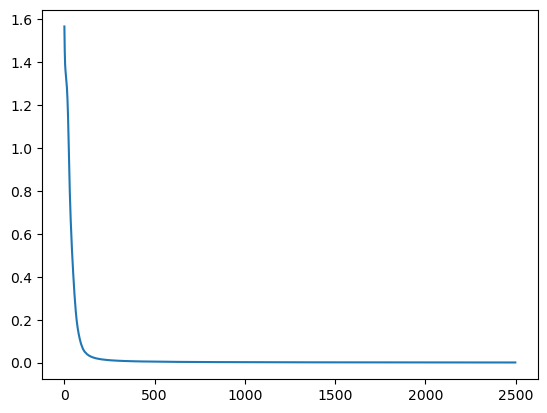

<Figure size 640x480 with 0 Axes>

In [69]:
plt.figure()
plt.plot(loss_array_train[:-1])
plt.show()

plt.savefig("plots/nmf_nn_trainloss.pdf", format="pdf", bbox_inches="tight")

In [39]:
labels.keys()

dict_keys(['left', 'right', 'straight', 'up'])

accuracy: 1.0


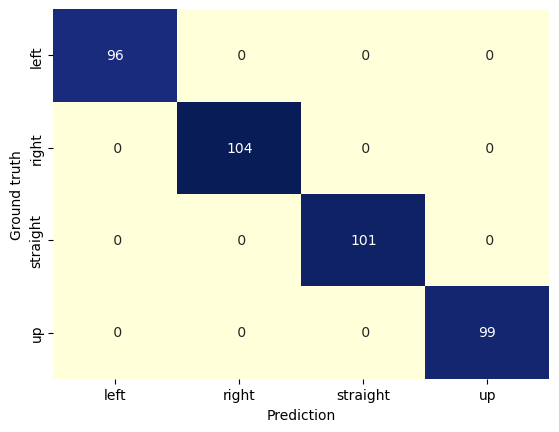

<Figure size 640x480 with 0 Axes>

In [70]:
confusion_matrix = np.zeros(shape=(4, 4))
for data, label in zip(train_embeddings, train_labels):
    data = data.reshape(-1, 1)
    out = model.forward(data)
    #print(out)
    loss = model.loss_layer.forward(out, label)
    confusion_matrix[label, np.argmax(out)] += 1
    epoch_loss_train += loss
print(f"accuracy: {confusion_matrix.trace()/confusion_matrix.sum()}")

plt.figure()
sns.heatmap(confusion_matrix.astype(int), annot=True, cbar=False, xticklabels=labels.keys(), yticklabels=labels.keys(), cmap="YlGnBu", fmt="2d")
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
#plt.title(f"")
plt.show()
plt.savefig("plots/nmf_nn_training_cm.pdf", format="pdf", bbox_inches="tight")

accuracy: 0.905511811023622


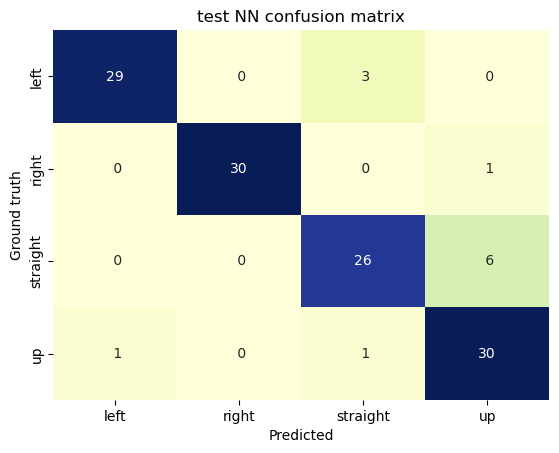

<Figure size 640x480 with 0 Axes>

In [71]:
confusion_matrix = np.zeros(shape=(4, 4))
epoch_loss_train = 0
for data, label in zip(test_embeddings, test_labels):
    data = data.reshape(-1, 1)
    out = model.forward(data)
    #print(out)
    loss = model.loss_layer.forward(out, one_hot_vector(label))
    confusion_matrix[label, np.argmax(out)] += 1
    epoch_loss_train += loss
print(f"accuracy: {confusion_matrix.trace()/confusion_matrix.sum()}")

plt.figure()
sns.heatmap(confusion_matrix.astype(int), annot=True, cbar=False, xticklabels=labels.keys(), yticklabels=labels.keys(), cmap="YlGnBu", fmt="2d")
plt.xlabel("Predicted")
plt.ylabel("Ground truth")
plt.title(f"test NN confusion matrix")
plt.show()
plt.savefig("plots/nmf_nn_test_cm.pdf", format="pdf", bbox_inches="tight")

In [3]:
dataset.data.shape

(624, 68, 1)

In [4]:
img = dataset.data[0]

In [5]:
dataset.orig_shape

(120, 128)

(68, 1)
(68, 15360)
(120, 128)
(120, 128)


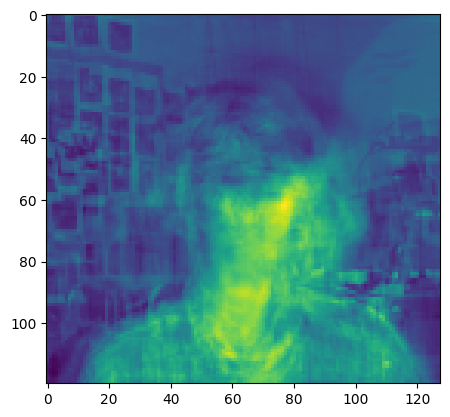

In [6]:
recon = dataset.get_reconstructed_image(0)
print(recon.shape)
plt.imshow(recon)

In [7]:
train, validation, test = train_test_split(dataset, (0.8, 0.0, 0.2))

In [8]:
train.label

array([0, 0, 2, 1, 2, 3, 3, 2, 3, 0, 3, 1, 0, 1, 0, 0, 1, 1, 3, 0, 1, 1,
       3, 3, 2, 3, 0, 2, 1, 3, 2, 3, 0, 2, 0, 1, 3, 0, 1, 3, 0, 3, 1, 0,
       1, 1, 1, 1, 0, 3, 3, 3, 1, 3, 2, 0, 0, 1, 2, 2, 0, 2, 2, 3, 2, 0,
       2, 3, 2, 2, 1, 0, 0, 0, 0, 1, 2, 2, 3, 1, 2, 2, 3, 1, 3, 2, 0, 2,
       1, 0, 2, 1, 1, 1, 3, 2, 3, 0, 3, 3, 2, 3, 3, 3, 3, 0, 1, 0, 1, 2,
       3, 2, 0, 1, 0, 3, 1, 0, 3, 3, 3, 1, 2, 0, 3, 0, 2, 1, 1, 0, 0, 0,
       3, 1, 2, 1, 1, 1, 2, 3, 3, 0, 1, 0, 0, 1, 1, 2, 3, 2, 0, 0, 2, 1,
       3, 3, 1, 1, 3, 3, 1, 2, 2, 0, 3, 1, 2, 1, 3, 0, 3, 1, 1, 3, 0, 1,
       2, 0, 2, 2, 2, 2, 3, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 3, 0, 2, 2, 3,
       2, 2, 1, 3, 0, 1, 1, 1, 0, 2, 0, 1, 2, 1, 1, 0, 0, 3, 3, 1, 1, 0,
       0, 1, 1, 3, 1, 3, 3, 1, 2, 0, 1, 1, 3, 2, 1, 2, 0, 0, 0, 3, 2, 2,
       1, 0, 2, 3, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 1, 3, 2, 0, 1, 3, 0, 0,
       2, 0, 2, 3, 1, 3, 0, 3, 1, 3, 2, 1, 0, 1, 3, 1, 0, 1, 2, 0, 2, 0,
       3, 0, 3, 0, 1, 3, 0, 2, 2, 0, 1, 3, 3, 0, 3,

In [9]:
input_shape = train[0][0].shape[0]

In [10]:
input_shape

68

In [11]:
linear1 = Linear(input_shape, input_shape//2)
relu1 = ReLU(linear1)
linear2 = Linear(input_shape//2, input_shape//4, relu1)
relu2 = ReLU(linear2)
linear3 = Linear(input_shape//4, input_shape//8, relu2)
relu3 = ReLU(linear3)
linear4 = Linear(input_shape//8, input_shape//16, relu3)
relu4 = ReLU(linear4)
linear5 = Linear(input_shape//16, len(dataset.keys), relu4)
softmaxlayer = Softmax(linear5)
loss_layer = CrossEntropy(softmaxlayer)

model = NeuralNetwork(linear1, softmaxlayer, loss_layer)

In [12]:
print(model.n_layers)
print(model.output_layer)

print("Forward order:")
for layer in model._forward_order:
    print(layer)

print("\nBackward order:")
for layer in model._backward_order:
    print(layer)

11
Forward order:
Linear: (68, 1) -> (34, 1)
ReLU
Linear: (34, 1) -> (17, 1)
ReLU
Linear: (17, 1) -> (8, 1)
ReLU
Linear: (8, 1) -> (4, 1)
ReLU
Linear: (4, 1) -> (4, 1)
Softmax
CrossEntropy

Backward order:
CrossEntropy
Softmax
Linear: (4, 1) -> (4, 1)
ReLU
Linear: (8, 1) -> (4, 1)
ReLU
Linear: (17, 1) -> (8, 1)
ReLU
Linear: (34, 1) -> (17, 1)
ReLU
Linear: (68, 1) -> (34, 1)


In [13]:
loss_array = []
pbar = tqdm(range(2500))
for i in pbar:
    epoch_loss = 0
    for data, label in train:
        data = data.reshape(-1, 1)
        out = model.forward(data)
        #print(out)
        loss = model.loss_layer.forward(out, label)
        epoch_loss += loss
        model.backward()
        model.step()
    epoch_loss = epoch_loss / len(train)
    loss_array.append(epoch_loss)
    pbar.set_description(str(epoch_loss))

[2.05921044e-05]: 100%|██████████| 2500/2500 [05:20<00:00,  7.80it/s]


In [14]:
loss_array

[array([1.42959419]),
 array([1.35052232]),
 array([1.27725381]),
 array([1.20450065]),
 array([1.13561503]),
 array([1.07349342]),
 array([1.01704804]),
 array([0.96728886]),
 array([0.92359487]),
 array([0.88144335]),
 array([0.83861692]),
 array([0.79559702]),
 array([0.75337402]),
 array([0.71063127]),
 array([0.66613212]),
 array([0.62078165]),
 array([0.57624349]),
 array([0.53149706]),
 array([0.48793805]),
 array([0.44414977]),
 array([0.40072502]),
 array([0.35948359]),
 array([0.32171774]),
 array([0.28795501]),
 array([0.25665291]),
 array([0.22983377]),
 array([0.2076986]),
 array([0.18862382]),
 array([0.17150939]),
 array([0.15585311]),
 array([0.13960151]),
 array([0.12434868]),
 array([0.11126484]),
 array([0.09928304]),
 array([0.08645113]),
 array([0.07381666]),
 array([0.06441016]),
 array([0.05735211]),
 array([0.05081409]),
 array([0.04630335]),
 array([0.04123751]),
 array([0.03685599]),
 array([0.0332415]),
 array([0.03045744]),
 array([0.02805293]),
 array([0.02

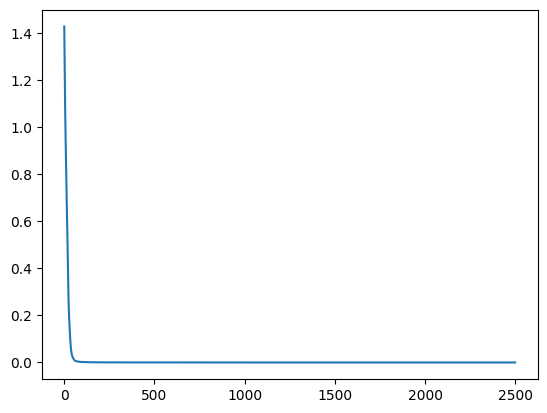

In [15]:
plt.plot(loss_array)

In [16]:
train.label

array([0, 0, 2, 1, 2, 3, 3, 2, 3, 0, 3, 1, 0, 1, 0, 0, 1, 1, 3, 0, 1, 1,
       3, 3, 2, 3, 0, 2, 1, 3, 2, 3, 0, 2, 0, 1, 3, 0, 1, 3, 0, 3, 1, 0,
       1, 1, 1, 1, 0, 3, 3, 3, 1, 3, 2, 0, 0, 1, 2, 2, 0, 2, 2, 3, 2, 0,
       2, 3, 2, 2, 1, 0, 0, 0, 0, 1, 2, 2, 3, 1, 2, 2, 3, 1, 3, 2, 0, 2,
       1, 0, 2, 1, 1, 1, 3, 2, 3, 0, 3, 3, 2, 3, 3, 3, 3, 0, 1, 0, 1, 2,
       3, 2, 0, 1, 0, 3, 1, 0, 3, 3, 3, 1, 2, 0, 3, 0, 2, 1, 1, 0, 0, 0,
       3, 1, 2, 1, 1, 1, 2, 3, 3, 0, 1, 0, 0, 1, 1, 2, 3, 2, 0, 0, 2, 1,
       3, 3, 1, 1, 3, 3, 1, 2, 2, 0, 3, 1, 2, 1, 3, 0, 3, 1, 1, 3, 0, 1,
       2, 0, 2, 2, 2, 2, 3, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 3, 0, 2, 2, 3,
       2, 2, 1, 3, 0, 1, 1, 1, 0, 2, 0, 1, 2, 1, 1, 0, 0, 3, 3, 1, 1, 0,
       0, 1, 1, 3, 1, 3, 3, 1, 2, 0, 1, 1, 3, 2, 1, 2, 0, 0, 0, 3, 2, 2,
       1, 0, 2, 3, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 1, 3, 2, 0, 1, 3, 0, 0,
       2, 0, 2, 3, 1, 3, 0, 3, 1, 3, 2, 1, 0, 1, 3, 1, 0, 1, 2, 0, 2, 0,
       3, 0, 3, 0, 1, 3, 0, 2, 2, 0, 1, 3, 3, 0, 3,

accuracy: 1.0


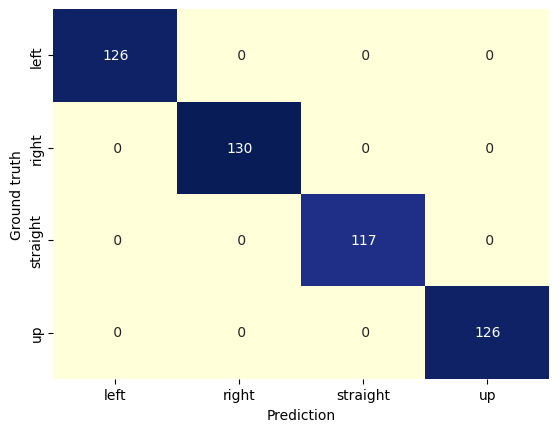

In [17]:
confusion_matrix = np.zeros(shape=[len(dataset.keys)]*2)
for data, label in train:
    data = data.reshape(-1, 1)
    out = model.forward(data)
    #print(out)
    loss = model.loss_layer.forward(out, label)
    confusion_matrix[np.argmax(label), np.argmax(out)] += 1
    epoch_loss += loss
print(f"accuracy: {confusion_matrix.trace()/confusion_matrix.sum()}")

plt.figure()
sns.heatmap(confusion_matrix.astype(int), annot=True, cbar=False, xticklabels=dataset.keys, yticklabels=dataset.keys, cmap="YlGnBu", fmt="2d")
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
#plt.title(f"")
plt.show()

accuracy: 0.912


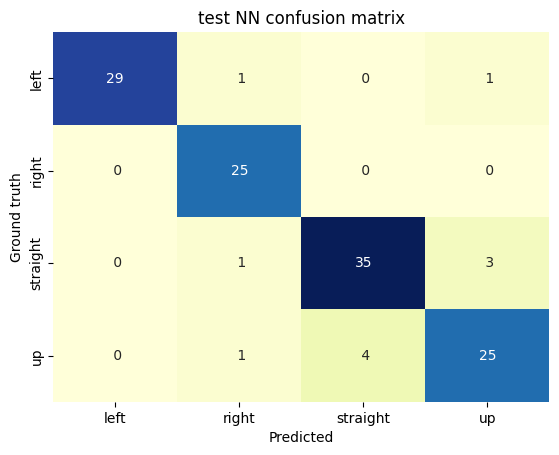

In [18]:
confusion_matrix = np.zeros(shape=[len(dataset.keys)]*2)
for data, label in test:
    data = data.reshape(-1, 1)
    out = model.forward(data)
    #print(out)
    loss = model.loss_layer.forward(out, label)
    confusion_matrix[np.argmax(label), np.argmax(out)] += 1
    epoch_loss += loss
print(f"accuracy: {confusion_matrix.trace()/confusion_matrix.sum()}")

plt.figure()
sns.heatmap(confusion_matrix.astype(int), annot=True, cbar=False, xticklabels=dataset.keys, yticklabels=dataset.keys, cmap="YlGnBu", fmt="2d")
plt.xlabel("Predicted")
plt.ylabel("Ground truth")
plt.title(f"test NN confusion matrix")
plt.show()

In [19]:
train[0][0].shape

(68,)

In [20]:
dataset.eig_idx

68